<a href="https://colab.research.google.com/github/Datasci266-Final-Project/Job-Listings/blob/main/Analysis%20Notebooks/Model_2_Testing_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Installs

!pip install pydot --quiet
!pip install transformers==4.37.2 --quiet
!pip install -U imbalanced-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 5.2 MB/s eta 0:00:00


In [ ]:
#@title Imports
import pandas as pd

import numpy as np
import random
import torch

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda, Dropout
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import re
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, TFBertModel, AutoTokenizer, TFXLMRobertaModel #"FacebookAI/xlm-roberta-base"

from transformers import logging
logging.set_verbosity_error()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# Set seed to 10

seed_value = 10

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/DataSci 266 Project

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1V3QooLePiHR_DaZhbXQhsjmP1Ez5fv5F/DataSci 266 Project


In [ ]:
# Dictionaries
level_key = {
    "student_intern": 0,
    "entry": 1,
    "junior": 2,
    "mid": 3,
    "senior": 4,
    "executive": 5,
    np.nan: -1
}

# Define salary_key dictionary
# salary_key = {
#     "<45k": 0,
#     "45-65k": 1,
#     "65-85k": 2,
#     "85-110k": 3,
#     "110-150k": 4,
#     "150-200k": 5,
#     ">200k": 6,
#     np.nan: -1
# }

salary_key = {
    "<50k": 0,
    "50-100k": 1,
    "100-150k": 2,
    "150-200k": 3,
    ">200k": 4,
    np.nan: -1
}

In [ ]:
#@title Import pickle files


#import tokenized inputs for each model
with open(r'Model Objects/Tokenized Inputs: Bert Base/test_inputs_bert.pickle', 'rb') as handle:
    bert_base_test_inputs = pickle.load(handle)

with open(r'Model Objects/Tokenized Inputs: Bert Multilingual/test_inputs_bert_multilingual.pickle', 'rb') as handle:
    bert_multilingual_test_inputs = pickle.load(handle)

with open(r'Model Objects/Tokenized Inputs: xlm-RoBERTa/test_inputs_xlm_roberta.pickle', 'rb') as handle:
    xlm_roberta_test_inputs = pickle.load(handle)


# import data
with open(r'Model Objects/model_2_test_data.pickle', 'rb') as handle:
    test_data = pickle.load(handle)


# import labels
with open(r'Model Objects/Labels/model_2_labels_level_test.pickle', 'rb') as handle:
    test_level_labels = pickle.load(handle)

with open(r'Model Objects/Labels/model_2_labels_salary_test.pickle', 'rb') as handle:
    test_salary_labels = pickle.load(handle)






In [ ]:
MAX_SEQUENCE_LENGTH = 512

In [ ]:
#@title Define Bert Model

# Masked Loss Function
def masked_loss_function(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_true, -1))  # Use -1 to represent missing values
    mask = tf.cast(mask, tf.float32)

    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32 to match the type of y_pred
    y_pred = tf.cast(y_pred, tf.float32)

    return tf.keras.losses.sparse_categorical_crossentropy(y_true * mask, y_pred * mask)




# BERT Model
def create_bert_multi_output_model(bert_base_model,
                                   trainable=True,
                                 max_sequence_length=MAX_SEQUENCE_LENGTH,
                                   num_level_classes=7,
                                   num_salary_classes=6,
                                 base_hidden_size=200,
                                  level_hidden_size=200,
                                  salary_hidden_size=200,
                                 dropout=0.3,
                                 learning_rate=0.00005,
                                   LEVEL_WEIGHT=0.5,
                                   SALARY_WEIGHT=0.5):

    bert_base_model.trainable = trainable

    # Input layers
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {
        'input_ids': input_ids,
        'token_type_ids': token_type_ids,
        'attention_mask': attention_mask
    }

    bert_out = bert_base_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]  # Extract CLS token
    pooler_token = bert_out[1]

    base_hidden = tf.keras.layers.Dense(base_hidden_size, activation='relu', name='base_hidden_layer_1')(cls_token)
    base_hidden = tf.keras.layers.Dense(base_hidden_size, activation='relu', name='base_hidden_layer_2')(base_hidden)
    base_out = tf.keras.layers.Dropout(dropout, name='base_dropout_1')(base_hidden)

    # job experience level
    level_hidden = tf.keras.layers.Dense(level_hidden_size, activation='relu', name='level_hidden_layer_1')(base_out)
    level_hidden = tf.keras.layers.Dense(level_hidden_size, activation='relu', name='level_hidden_layer_2')(level_hidden)
    level_hidden = tf.keras.layers.Dropout(dropout, name='level_dropout_1')(level_hidden)
    level_classification = tf.keras.layers.Dense(num_level_classes, activation='softmax', name='level_classification')(level_hidden)

    # salary bucket
    salary_hidden = tf.keras.layers.Dense(salary_hidden_size, activation='relu', name='salary_hidden_layer_1')(base_out)
    salary_hidden = tf.keras.layers.Dense(salary_hidden_size, activation='relu', name='salary_hidden_layer_2')(salary_hidden)
    salary_hidden = tf.keras.layers.Dropout(dropout, name='salary_dropout_1')(salary_hidden)
    salary_classification = tf.keras.layers.Dense(num_salary_classes, activation='softmax', name='salary_classification')(salary_hidden)



    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask],
                                          outputs=[level_classification, salary_classification])


    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss={'level_classification': masked_loss_function,
                                       'salary_classification': masked_loss_function},
                                 loss_weights=[LEVEL_WEIGHT,
                                               SALARY_WEIGHT],
                                 metrics={'level_classification': 'accuracy',
                                          'salary_classification': 'accuracy'})

    return classification_model




In [ ]:
#@title Define xlm-roberta Model

# Masked Loss Function
def masked_loss_function(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_true, -1))  # Use -1 to represent missing values
    mask = tf.cast(mask, tf.float32)

    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32 to match the type of y_pred
    y_pred = tf.cast(y_pred, tf.float32)

    return tf.keras.losses.sparse_categorical_crossentropy(y_true * mask, y_pred * mask)




# BERT Model
def create_xlm_roberta_multi_output_model(xlm_roberta_model,
                                   trainable=True,
                                 max_sequence_length=MAX_SEQUENCE_LENGTH,
                                   num_level_classes=7,
                                   num_salary_classes=6,
                                 base_hidden_size=200,
                                  level_hidden_size=200,
                                  salary_hidden_size=200,
                                 dropout=0.3,
                                 learning_rate=0.00001,
                                   LEVEL_WEIGHT=0.5,
                                   SALARY_WEIGHT=0.5):

    xlm_roberta_model.trainable = trainable

    # Input layers
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    xlm_roberta_inputs = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }

    xlm_roberta_out = xlm_roberta_model(xlm_roberta_inputs)

    cls_token = xlm_roberta_out[0][:, 0, :]  # Extract CLS token
    #pooler_token = bert_out[1]

    base_hidden = tf.keras.layers.Dense(base_hidden_size, activation='relu', name='base_hidden_layer_1')(cls_token)
    base_hidden = tf.keras.layers.Dense(base_hidden_size, activation='relu', name='base_hidden_layer_2')(base_hidden)
    base_out = tf.keras.layers.Dropout(dropout, name='base_dropout_1')(base_hidden)

    # job experience level
    level_hidden = tf.keras.layers.Dense(level_hidden_size, activation='relu', name='level_hidden_layer_1')(base_out)
    level_hidden = tf.keras.layers.Dense(level_hidden_size, activation='relu', name='level_hidden_layer_2')(level_hidden)
    level_hidden = tf.keras.layers.Dropout(dropout, name='level_dropout_1')(level_hidden)
    level_classification = tf.keras.layers.Dense(num_level_classes, activation='softmax', name='level_classification')(level_hidden)

    # salary bucket
    salary_hidden = tf.keras.layers.Dense(salary_hidden_size, activation='relu', name='salary_hidden_layer_1')(base_out)
    salary_hidden = tf.keras.layers.Dense(salary_hidden_size, activation='relu', name='salary_hidden_layer_2')(salary_hidden)
    salary_hidden = tf.keras.layers.Dropout(dropout, name='salary_dropout_1')(salary_hidden)
    salary_classification = tf.keras.layers.Dense(num_salary_classes, activation='softmax', name='salary_classification')(salary_hidden)



    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask],
                                          outputs=[level_classification, salary_classification])


    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss={'level_classification': masked_loss_function,
                                       'salary_classification': masked_loss_function},
                                 loss_weights=[LEVEL_WEIGHT,
                                               SALARY_WEIGHT],
                                 metrics={'level_classification': 'accuracy',
                                          'salary_classification': 'accuracy'})

    return classification_model




In [ ]:
# bert base model from pre-saved weights
bert_base_model = TFBertModel.from_pretrained('bert-base-cased')
bert_base_model = create_bert_multi_output_model(bert_base_model)

bert_base_model.load_weights('./Model Objects/model_2_bert/model_2_bert_base_weights')


# xlm_roberta model from pre-saved weights
xlm_roberta_model = TFXLMRobertaModel.from_pretrained("FacebookAI/xlm-roberta-base")
xlm_roberta_model = create_xlm_roberta_multi_output_model(xlm_roberta_model)

xlm_roberta_model.load_weights('./Model Objects/model_2_xlm_roberta_5_epochs/model_2_xlm_roberta_weights')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
# bert_base_model.evaluate(bert_base_test_inputs,
#                             [test_level_labels, test_salary_labels])

In [ ]:
# bert_multilingual_model.evaluate(bert_multilingual_test_inputs,
#                             [test_level_labels, test_salary_labels])

In [ ]:
# xlm_roberta_model.evaluate(xlm_roberta_test_inputs,
#                             [test_level_labels, test_salary_labels])

In [ ]:
#set target level names and target salary names
target_names = ["student_intern", "entry", "junior", "mid", "senior", "executive"]
target_salary_names = ["<50k",
    "50-100k",
    "100-150k",
    "150-200k",
    ">200k"]




In [ ]:
predictions_bert_base = bert_base_model.predict(bert_base_test_inputs)
predictions_xlm_roberta = xlm_roberta_model.predict(xlm_roberta_test_inputs)




440/440 [==============================] - 172s 384ms/step


In [ ]:
level_predictions_bert_base = tf.argmax(predictions_bert_base[0], axis=-1)
salary_predictions_bert_base = tf.argmax(predictions_bert_base[1], axis=-1)


level_predictions_xlm_roberta = tf.argmax(predictions_xlm_roberta[0], axis=-1)
salary_predictions_xlm_roberta = tf.argmax(predictions_xlm_roberta[1], axis=-1)


In [ ]:
test_level_labels = test_level_labels.apply(lambda x: 6 if x == -1 else x)


In [ ]:
test_level_analysis_df = pd.DataFrame(test_level_labels)
test_level_analysis_df.columns = ["test_level"]
test_level_analysis_df["level_predictions_bert_base"] = level_predictions_bert_base
test_level_analysis_df["level_predictions_xlm_roberta"] = level_predictions_xlm_roberta
test_level_analysis_df = test_level_analysis_df[test_level_analysis_df["test_level"] != 6]

In [ ]:
sum(test_level_analysis_df['test_level'].isnull())

0

In [ ]:
# bert base levels confusion matrix
cm = tf.math.confusion_matrix(test_level_analysis_df['test_level'], test_level_analysis_df['level_predictions_bert_base'])
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(0.5, 1.0, 'Model 2: BERT Base - Level')

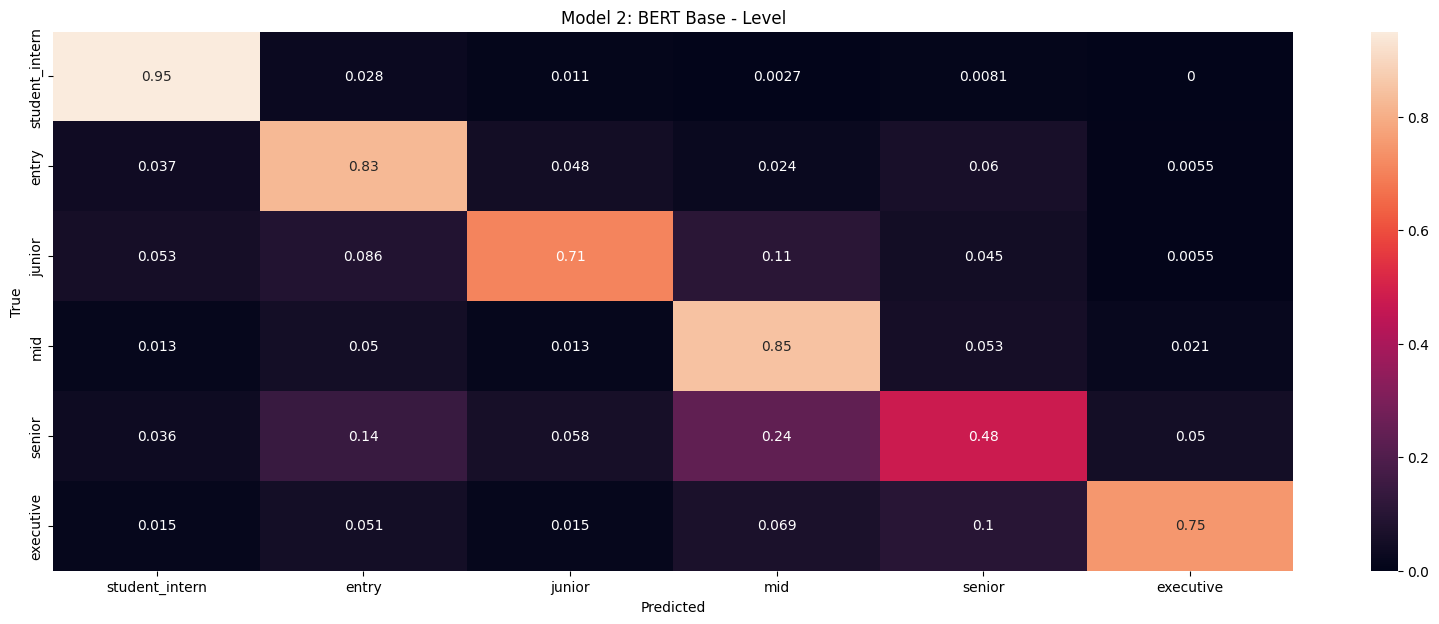

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Model 2: BERT Base - Level")

In [ ]:
test_salary_labels = test_salary_labels.apply(lambda x: 5 if x == -1 else x)

In [ ]:
test_salary_labels.value_counts()

salary_labels
5    11770
1     1133
0      722
2      267
4       88
3       83
Name: count, dtype: int64

In [ ]:
test_salary_analysis_df = pd.DataFrame(test_salary_labels)
test_salary_analysis_df.columns = ["test_salary"]
test_salary_analysis_df["salary_predictions_bert_base"] = salary_predictions_bert_base
test_salary_analysis_df["salary_predictions_xlm_roberta"] = salary_predictions_xlm_roberta
test_salary_analysis_df = test_salary_analysis_df[test_salary_analysis_df["test_salary"] != 5]

In [ ]:
sum(test_salary_analysis_df['test_salary'].isnull())

0

In [ ]:
cm = tf.math.confusion_matrix(test_salary_analysis_df['test_salary'], test_salary_analysis_df['salary_predictions_bert_base'])
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(0.5, 1.0, 'Model 2: BERT Base - Salary')

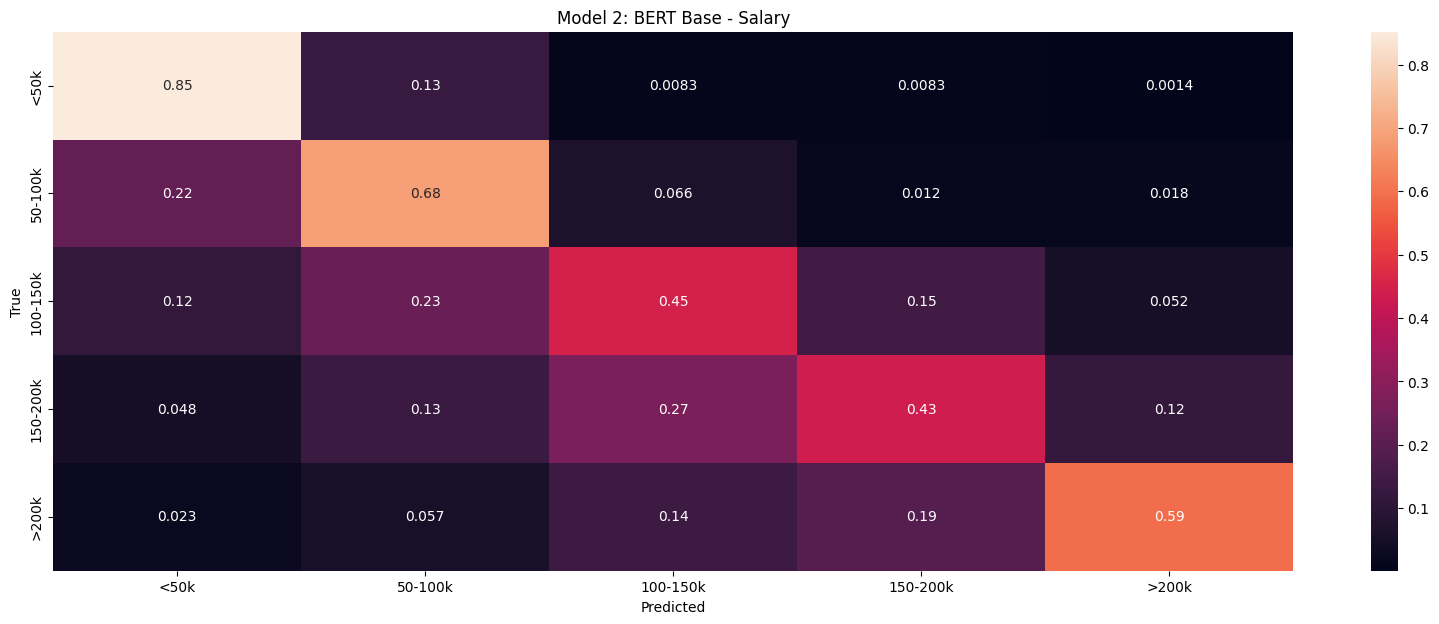

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_salary_names,
    yticklabels=target_salary_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Model 2: BERT Base - Salary")

In [ ]:
# calculate adjusted salary accuracy for bert base
print("Model 2: Bert Base Salary Accuracy")
no_label_salary_percent = sum(test_salary_labels == 5)/len(test_salary_labels)
correct_salary_percent = sum(test_salary_labels == salary_predictions_bert_base.numpy())/len(test_salary_labels)
incorrect_salary_percent = 1 - correct_salary_percent
print("% Salary inputs with no label:",no_label_salary_percent)
print("% Salary predictions correct:",correct_salary_percent)
print("% Salary predictions incorrect:",incorrect_salary_percent)

adjusted_salary_accuracy = correct_salary_percent / (correct_salary_percent + (incorrect_salary_percent - no_label_salary_percent))
print("Adjusted Salary Accuracy:",adjusted_salary_accuracy)

Model 2: Bert Base Salary Accuracy
% Salary inputs with no label: 0.8369480196259689
% Salary predictions correct: 0.11370262390670553
% Salary predictions incorrect: 0.8862973760932945
Adjusted Salary Accuracy: 0.697339729611862


In [ ]:
# calculate adjusted level accuracy for bert base
print("Model 2: Bert Base Level Accuracy")

no_label_level_percent = sum(test_level_labels == 6)/len(test_level_labels)
correct_level_percent = sum(test_level_labels == level_predictions_bert_base.numpy())/len(test_level_labels)
incorrect_level_percent = 1 - correct_level_percent
print("% Level inputs with no label:",no_label_level_percent)
print("% Level predictions correct:",correct_level_percent)
print("% Level predictions incorrect:",incorrect_level_percent)

adjusted_level_accuracy = correct_level_percent / (correct_level_percent + (incorrect_level_percent - no_label_level_percent))
print("Adjusted Level Accuracy:",adjusted_level_accuracy)

Model 2: Bert Base Level Accuracy
% Level inputs with no label: 0.12522221432126857
% Level predictions correct: 0.5734196117471378
% Level predictions incorrect: 0.42658038825286215
Adjusted Level Accuracy: 0.655503170216225


Text(0.5, 1.0, 'Model 2: xlm-roberta - Level')

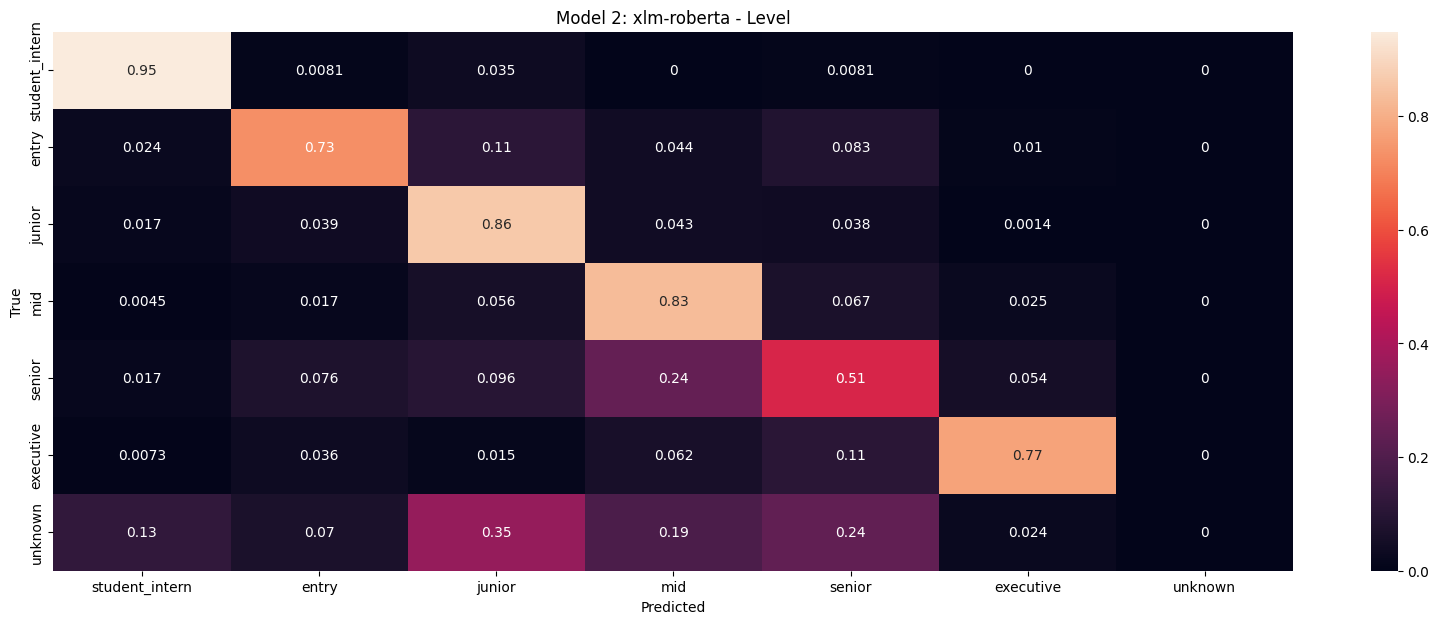

In [ ]:
# xlm-roberta levels confusion matrix
cm = tf.math.confusion_matrix(test_level_labels, level_predictions_xlm_roberta)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Model 2: xlm-roberta - Level")

Text(0.5, 1.0, 'Model 2: xlm-roberta - Salary')

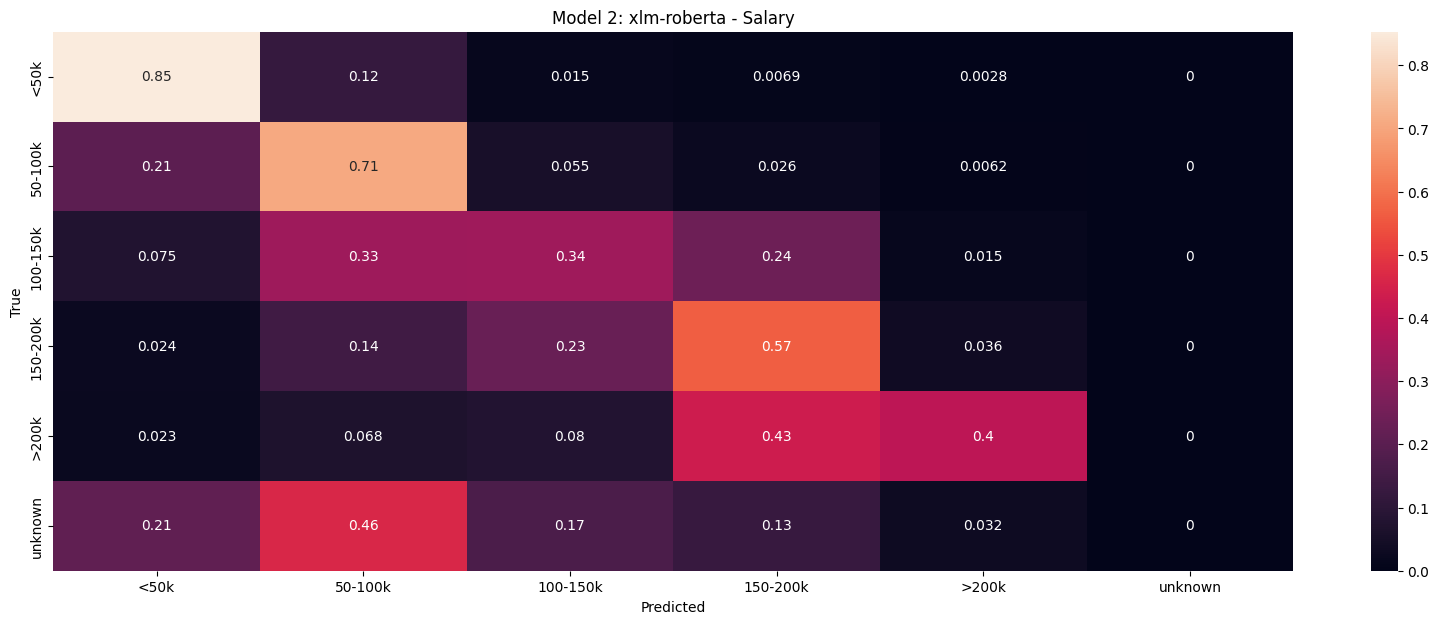

In [ ]:
cm = tf.math.confusion_matrix(test_salary_labels, salary_predictions_xlm_roberta)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_salary_names,
    yticklabels=target_salary_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Model 2: xlm-roberta - Salary")

In [ ]:
# calculate adjusted salary accuracy for xlm-roberta
print("Model 2: xlm-roberta Salary Accuracy")
no_label_salary_percent = sum(test_salary_labels == 5)/len(test_salary_labels)
correct_salary_percent = sum(test_salary_labels == salary_predictions_xlm_roberta.numpy())/len(test_salary_labels)
incorrect_salary_percent = 1 - correct_salary_percent
print("% Salary inputs with no label:",no_label_salary_percent)
print("% Salary predictions correct:",correct_salary_percent)
print("% Salary predictions incorrect:",incorrect_salary_percent)

adjusted_salary_accuracy = correct_salary_percent / (correct_salary_percent + (incorrect_salary_percent - no_label_salary_percent))
print("Adjusted Salary Accuracy:",adjusted_salary_accuracy)

Model 2: xlm-roberta Salary Accuracy
% Salary inputs with no label: 0.8369480196259689
% Salary predictions correct: 0.11299153807864609
% Salary predictions incorrect: 0.8870084619213539
Adjusted Salary Accuracy: 0.6929786306149153


In [ ]:
# calculate adjusted level accuracy for xlm-roberta
print("Model 2: xlm-roberta Level Accuracy")

no_label_level_percent = sum(test_level_labels == 6)/len(test_level_labels)
correct_level_percent = sum(test_level_labels == level_predictions_xlm_roberta.numpy())/len(test_level_labels)
incorrect_level_percent = 1 - correct_level_percent
print("% Level inputs with no label:",no_label_level_percent)
print("% Level predictions correct:",correct_level_percent)
print("% Level predictions incorrect:",incorrect_level_percent)

adjusted_level_accuracy = correct_level_percent / (correct_level_percent + (incorrect_level_percent - no_label_level_percent))
print("Adjusted Level Accuracy:",adjusted_level_accuracy)

Model 2: xlm-roberta Level Accuracy
% Level inputs with no label: 0.12522221432126857
% Level predictions correct: 0.5877124368911327
% Level predictions incorrect: 0.41228756310886727
Adjusted Level Accuracy: 0.6718419769143228


In [ ]:
print('Model 2: BERT Base - Level Classification Metrics')
print(classification_report(test_level_analysis_df['test_level'], test_level_analysis_df['level_predictions_bert_base'], target_names=target_names))

print('')
print('-'*20)
print('')

print('Model 2: BERT Base - Salary Classification Metrics')
print(classification_report(test_salary_analysis_df['test_salary'], test_salary_analysis_df['salary_predictions_bert_base'], target_names=target_salary_names))

print('')
print('='*20)
print('')

print('Model 2: xlm-Roberta - Level Classification Metrics')
print(classification_report(test_level_analysis_df['test_level'], test_level_analysis_df['level_predictions_xlm_roberta'], target_names=target_names))

print('')
print('-'*20)
print('')

print('Model 2: xlm-Roberta - Salary Classification Metrics')
print(classification_report(test_salary_analysis_df['test_salary'], test_salary_analysis_df['salary_predictions_xlm_roberta'], target_names=target_salary_names))

Model 2: BERT Base - Level Classification Metrics
                precision    recall  f1-score   support

student_intern       0.64      0.95      0.77       743
         entry       0.60      0.83      0.70      1991
        junior       0.68      0.71      0.69      1450
           mid       0.51      0.85      0.64      1989
        senior       0.90      0.48      0.62      5855
     executive       0.37      0.75      0.49       274

      accuracy                           0.66     12302
     macro avg       0.62      0.76      0.65     12302
  weighted avg       0.73      0.66      0.65     12302


--------------------

Model 2: BERT Base - Salary Classification Metrics
              precision    recall  f1-score   support

        <50k       0.68      0.85      0.76       722
     50-100k       0.82      0.68      0.75      1133
    100-150k       0.51      0.45      0.48       267
    150-200k       0.32      0.43      0.37        83
       >200k       0.54      0.59      0.5

In [ ]:
test_data

,index,title,text,level,salary,salary_bucket,level_labels,salary_labels
0,17953,Real Estate Fund Accounting Senior Client Mana...,Credit Suisse is a leading global wealth manag...,senior,NaN,NaN,4,-1
1,97031,Investment Analyst,<p><strong><u>INVESTMENT ANALYST in Luxembourg...,junior,NaN,NaN,2,-1
2,64933,Accounts payable accountant Fr-En (M/F),Job Description LE POSTE : For one of our clie...,NaN,55000.0,50-100k,-1,1
3,79240,Concepteur d'offres de formation - Division du...,Missions Le concepteur d’offre sera en charge ...,entry,NaN,NaN,1,-1
4,89706,SC Analyst,"Description At Amazon Logistics (AMZL), we str...",junior,NaN,NaN,2,-1
...,...,...,...,...,...,...,...,...
14058,38581,Fund Services Officer - Senior AML/CTF Transfe...,Fund Services Officer - Senior AML/CTF Transfe...,senior,NaN,NaN,4,-1
14059,81160,Full-stack Blockchain Engineer (m/f/d) - 100% ...,Description Contribute to the mainstream adopt...,senior,192500.0,150-200k,4,3
14060,40835,Junior Officer - Accounting Services,"Arendt Services, which is part of Arendt & Med...",junior,NaN,NaN,2,-1
14061,2116,Attorney,Posting Date 05/04/23 Application Deadline 05/...,junior,NaN,NaN,2,-1


In [ ]:
print(level_predictions_bert_base.numpy()[1])

3


In [ ]:
reverse_level_key = {
    0:"student_intern",
    1:"entry",
    2:"junior",
    3:"mid",
    4:"senior",
    5:"executive",
    -1:np.nan
}



reverse_salary_key = {
    0:"<50k",
    1:"50-100k",
    2:"100-150k",
    3:"150-200k",
    4:">200k",
    -1:np.nan
}

In [ ]:
xlm_predictions_data = test_data.copy()


for i in range(len(xlm_predictions_data)):
  xlm_predictions_data.loc[i,8] = level_predictions_xlm_roberta.numpy()[i]
  xlm_predictions_data.loc[i,9] = salary_predictions_xlm_roberta.numpy()[i]

xlm_predictions_data.columns = ['index','title','text','level','salary','salary_bucket','level_labels','salary_labels','level_prediction','salary_prediction']
xlm_predictions_data['level_prediction'] = xlm_predictions_data['level_prediction'].astype(int)
xlm_predictions_data['salary_prediction'] = xlm_predictions_data['salary_prediction'].astype(int)

xlm_predictions_data['level_prediction_text'] = xlm_predictions_data['level_prediction'].map(reverse_level_key)
xlm_predictions_data['salary_prediction_text'] = xlm_predictions_data['salary_prediction'].map(reverse_salary_key)
print(xlm_predictions_data.head())



   index                                              title  \
0  17953  Real Estate Fund Accounting Senior Client Mana...   
1  97031                                 Investment Analyst   
2  64933            Accounts payable accountant Fr-En (M/F)   
3  79240  Concepteur d'offres de formation - Division du...   
4  89706                                         SC Analyst   

                                                text   level   salary  \
0  Credit Suisse is a leading global wealth manag...  senior      NaN   
1  <p><strong><u>INVESTMENT ANALYST in Luxembourg...  junior      NaN   
2  Job Description LE POSTE : For one of our clie...     NaN  55000.0   
3  Missions Le concepteur d’offre sera en charge ...   entry      NaN   
4  Description At Amazon Logistics (AMZL), we str...  junior      NaN   

  salary_bucket  level_labels  salary_labels  level_prediction  \
0           NaN             4             -1                 5   
1           NaN             2             -1      

In [ ]:
xlm_predictions_data.dtypes

index                       int64
title                      object
text                       object
level                      object
salary                    float64
salary_bucket              object
level_labels                int64
salary_labels               int64
level_prediction            int64
salary_prediction           int64
level_prediction_text      object
salary_prediction_text     object
dtype: object

In [ ]:
xlm_incorrect_predictions = xlm_predictions_data[((xlm_predictions_data['level_prediction'] != xlm_predictions_data['level_labels']) & (xlm_predictions_data['level_labels'] != -1)) | ((xlm_predictions_data['salary_prediction'] != xlm_predictions_data['salary_labels']) & (xlm_predictions_data['salary_labels'] != -1))]
xlm_incorrect_predictions.head()

,index,title,text,level,salary,salary_bucket,level_labels,salary_labels,level_prediction,salary_prediction,level_prediction_text,salary_prediction_text
0,17953,Real Estate Fund Accounting Senior Client Mana...,Credit Suisse is a leading global wealth manag...,senior,NaN,NaN,4,-1,5,2,executive,100-150k
2,64933,Accounts payable accountant Fr-En (M/F),Job Description LE POSTE : For one of our clie...,NaN,55000.0,50-100k,-1,1,1,0,entry,<50k
3,79240,Concepteur d'offres de formation - Division du...,Missions Le concepteur d’offre sera en charge ...,entry,NaN,NaN,1,-1,4,1,senior,50-100k
4,89706,SC Analyst,"Description At Amazon Logistics (AMZL), we str...",junior,NaN,NaN,2,-1,4,1,senior,50-100k
7,67315,Senior Accountant - German Tax Specialist,Job Description Le Grand & Associates guarante...,senior,NaN,NaN,4,-1,3,1,mid,50-100k


In [ ]:
import textwrap

In [ ]:
for index, job in xlm_incorrect_predictions.head().iterrows():
    print(job['title'])
    print(f"Predicted Level: {job['level_prediction_text']} Actual Level: {job['level']}")
    print(f"Predicted Salary: {job['salary_prediction_text']} Actual Salary: {job['salary']}")
    print(textwrap.fill(job['text'],200))
    print('')

Real Estate Fund Accounting Senior Client Manager - Luxembourg
Predicted Level: executive Actual Level: senior
Predicted Salary: 100-150k Actual Salary: nan
Credit Suisse is a leading global wealth manager with strong investment banking capabilities. Headquartered in Zurich, Switzerland, we have a global reach with operations in about 50 countries and
employ more than 45,000 people from over 150 different nations. Embodying entrepreneurial spirit, Credit Suisse delivers holistic financial solutions to our clients, including innovative products and
specially tailored advice. Striving for quality and excellence in our work, we recognize and reward extraordinary performance among our employees, provide wide-ranging training and development
opportunities, and benefit from a diverse range of perspectives to create value for our clients, shareholders and communities. We are Credit Suisse. We offer Are you looking for an exciting challenge
and describe yourself as a dynamic team-player who ha

In [ ]:
# bert_base_train_inputs[0].numpy()

# token_lengths = []
# for i in bert_base_train_inputs[0].numpy():
#     num_tokens = sum(i != 0)
#     token_lengths.append(num_tokens)
# max_tokens = max(token_lengths)
# print(max_tokens)
# plt.hist(token_lengths)

Correct = 8/100
N/A = 60/100

Incorrect = 32/100 = 92 - 60 / 100

New Accuracy = 8 / 8+32 = 20/100 = 20%

For bucket adjustment, go to 50k buckets.
<50k, 50-100, 100-150, 150-200, 200+

Hyperparameters:
number levels remain the same
number salary goes from 8 -> 6

Look at ways to reduce compute (reduce max tokens? - NO, many at 512 tokens)

We considered another model that could use more tokens, but accuracy at 512 was decent at baseline, and we didn't want to incur the extra compute/time.

Increase additional hidden layer to each of base, salary, level.  Widden hidden layers to 200

try JobBERT